## Parameters

In [1]:
indir <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/filtered_peak_bc_matrix/"
frag_gz <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/fragments.tsv.gz"
indir_mgatk <- "/data2/mito_lineage/data/processed/mttrace/CHIP_april08_2021/MTblacklist/Flt3l/MT/cellr_True/Flt3l_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/"
name <- "Flt3l"
outdir <- "/data2/mito_lineage/Analysis/annotation/output/data/"
prefix <- "CHIP_april08_2021_Croker/MTblacklist/"

In [2]:
outdir <- file.path(outdir, prefix)
dir.create(outdir, recursive=TRUE, showWarnings = TRUE)

Warning message in dir.create(outdir, recursive = TRUE, showWarnings = TRUE):
“'/data2/mito_lineage/Analysis/annotation/output/data//CHIP_april08_2021_Croker/MTblacklist' already exists”


In [3]:
peaks_cd34_f <- "/data2/mito_lineage/Analysis/annotation/data/granja_cd34/GSE129785_scATAC-Hematopoiesis-CD34.peaks.bed"

In [4]:
# install.packages("dplyr")
# install.packages("ggrastr")
# install.packages("SummarizedExperiment")
# install.packages("ggrastr")
# #if (!requireNamespace("BiocManager", quietly = TRUE))
# install.packages("BiocManager")
# BiocManager::install("GenomicRanges")
# install.packages('devtools')
# devtools::install_github("caleblareau/BuenColors")

In [5]:
library(SummarizedExperiment)
library(data.table)
library(GenomicRanges)
library(dplyr)
library(ggrastr)
library(BuenColors)
library("diffloop")

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

In [6]:
frag_gz_file <- frag_gz
exp <- 'Flt3l'
frip_threshold <- 0.01

In [7]:
#peaks_pan_heme <-diffloop::bedToGRanges("../data/29August2017_EJCsamples_allReads_500bp.bed")
#peaks_cd34 <-diffloop::bedToGRanges("../data/granja_cd34/GSE129785_scATAC-Hematopoiesis-CD34.peaks.bed")
peaks_cd34 <-diffloop::bedToGRanges(peaks_cd34_f)
peaks_external <- peaks_cd34

# Import experiment to make an RDS of the SE and a basic qc plot
qcdf <- fread(file.path(indir,"barcodes.tsv"), header = FALSE, sep = ",", col.names=c('cell_id')) %>% 
data.frame() %>% filter(cell_id != "None")
bc <- as.character(qcdf$cell_id)
#SE <- getCountsFromFrags(frag_gz_file, peaks, bc) #), peaks, bc)
# Make GRanges of fragments that are solid for the cells that we care about
frags <- data.table::as.data.table(read.table(frag_gz_file, comment.char="%",header=FALSE, sep = '\t'))
print(colnames(frags))
frags_valid <- frags %>% data.frame() %>% filter(V4 %in% bc) %>% GenomicRanges::makeGRangesFromDataFrame(seqnames.field = "V1", start.field = "V2", end.field = "V3", keep.extra.columns = TRUE)


[1] "V1" "V2" "V3" "V4" "V5"


In [8]:
# Get a denominator, per cell
denom <- table(GenomicRanges::mcols(frags_valid)$V4)
barcodes_found <- names(denom)


In [9]:
# Get the overlaps with peaks
ovPEAK <- GenomicRanges::findOverlaps(peaks_external, frags_valid)


In [10]:
# Establish a numeric index for the barcodes for sparse matrix purposes
id <- factor(as.character(GenomicRanges::mcols(frags_valid)$V4), levels = barcodes_found)

# Make sparse matrix with counts with peaks by  unique barcode
countdf <- data.frame(peaks = S4Vectors::queryHits(ovPEAK),
                    sample = as.numeric(id)[S4Vectors::subjectHits(ovPEAK)]) %>%
dplyr::group_by(peaks,sample) %>% dplyr::summarise(count = n()) %>% data.matrix()

m <- Matrix::sparseMatrix(i = c(countdf[,1], length(peaks_external)),
                        j = c(countdf[,2], length(barcodes_found)),
                        x = c(countdf[,3],0))
colnames(m) <- barcodes_found

# Make a polished colData
colData <- data.frame(
sample = barcodes_found,
depth = as.numeric(denom),
FRIP = Matrix::colSums(m)/as.numeric(denom)
)
# Make sure that the SE can be correctly constructed
stopifnot(all(colData$sample == colnames(m)))

# Make summarized Experiment
SE <- SummarizedExperiment::SummarizedExperiment(
rowRanges = peaks_external,
assays = list(counts = m),
colData = colData
)


`summarise()` has grouped output by 'peaks'. You can override using the `.groups` argument.



In [11]:
SE

class: RangedSummarizedExperiment 
dim: 571389 5313 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(5313): AAACGAAAGGAAACTT-1 AAACGAAGTCCAAGAG-1 ...
  TTTGTGTTCTCTGTTA-1 TTTGTGTTCTTCTTCC-1
colData names(3): sample depth FRIP

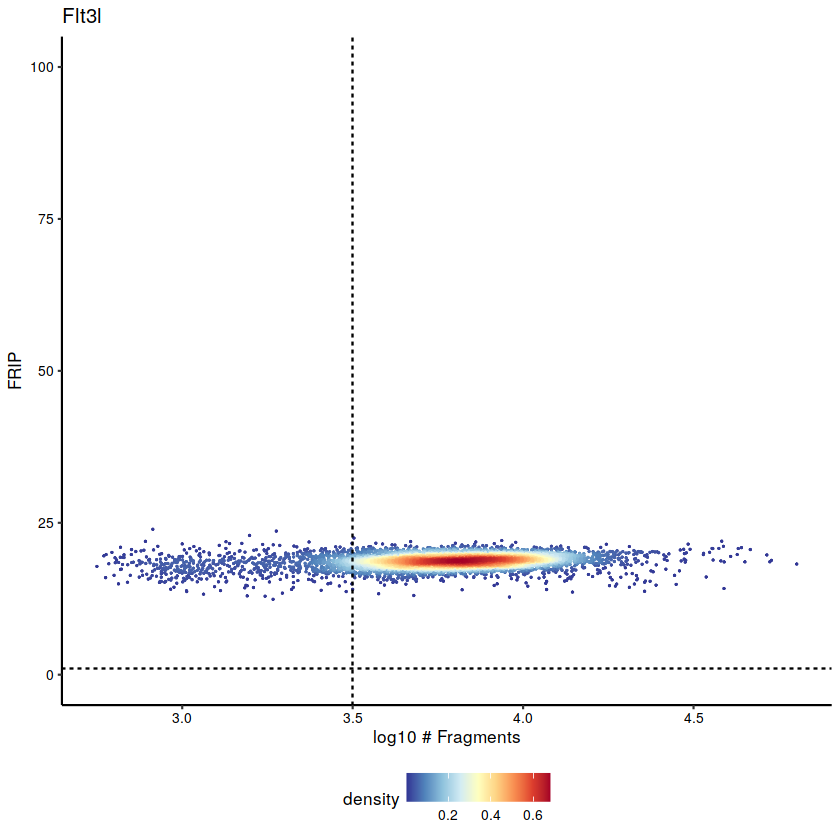

In [12]:
options(jupyter.plot_mimetypes = 'image/png')

df <- data.frame(colData(SE))

if(TRUE){
df$density <- get_density(log10(df$depth + 1), df$FRIP*100)
p1 <- ggplot(df %>% arrange(density), aes(x = log10(depth + 1),  y = FRIP*100, color = density)) +
  geom_point_rast(size = 0.1) + scale_color_gradientn(colors = jdb_palette("brewer_celsius")) +
  pretty_plot() + L_border() + labs(x = "log10 # Fragments", y = "FRIP") +
  theme(legend.position = "bottom") + ggtitle(exp) +
  geom_vline(xintercept = 3.5, linetype = 2) +
  geom_hline(yintercept = frip_threshold*100, linetype = 2) +
  scale_y_continuous(limits = c(0,100))
}
print(p1)

In [14]:
# Import mtDNA DF
cov_mtDNA <- data.frame(colData(readRDS(paste0(indir_mgatk, exp, ".variant.rds"))))
vec <- as.numeric(cov_mtDNA$depth); names(vec) <- as.character(cov_mtDNA$sample)
colData(SE)$mtDNAcoverage <- vec[as.character(df$sample)] %>% unname()
df$mtDNAcoverage <- vec[as.character(df$sample)] %>% unname()

In [24]:
sum(df$mtDNAcoverage < 20, na.rm=TRUE)


[1] 33

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 1190 rows containing non-finite values (stat_bin).”


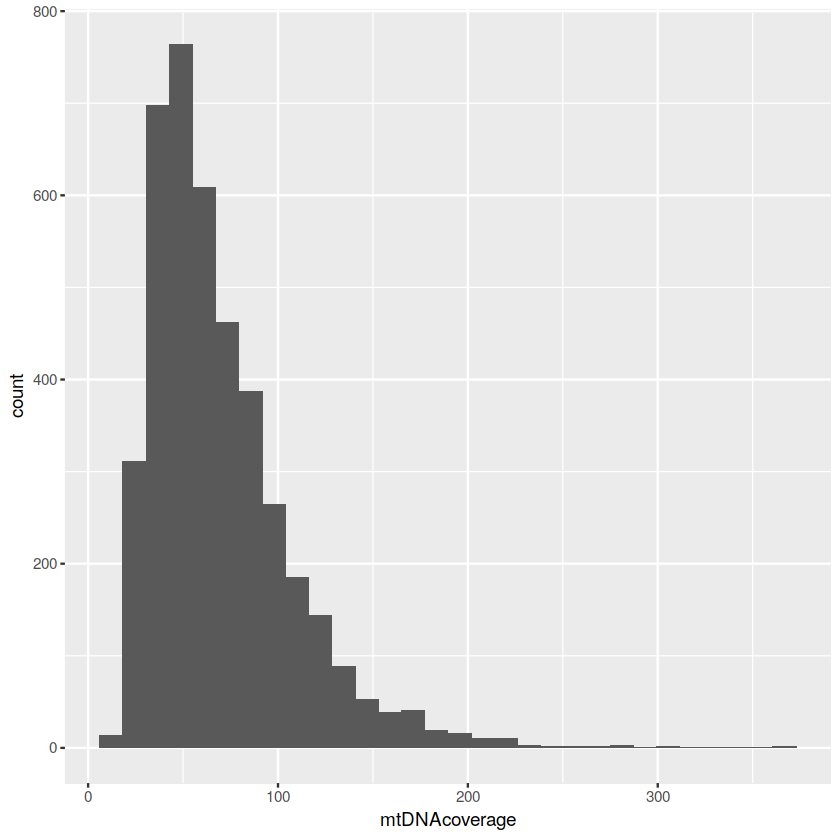

In [29]:
p<- ggplot(df, aes(x=mtDNAcoverage)) + geom_histogram()
print(p)

In [16]:
df$keep <- log10(df$depth) >= 3 & df$FRIP >= frip_threshold & df$mtDNAcoverage >= 20

df$keep[is.na(df$keep)]<-FALSE
df$keep

In [30]:
SE2 <- SE[, df$keep]
saveRDS(SE2, file = file.path(outdir, paste0(exp, ".rds")))
write.table(df, file = file.path(outdir, paste0(exp, ".barcode_qc.tsv")), sep = "\t", quote = FALSE, row.names = FALSE, col.names = TRUE)
print(dim(SE2))

df$density <- get_density(log10(df$depth + 1), df$FRIP*100)




[1] 571389   4073


In [31]:
SE2

class: RangedSummarizedExperiment 
dim: 571389 4073 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(4073): AAACGAAAGGAAACTT-1 AAACGAAGTCCAAGAG-1 ...
  TTTGTGTTCGCTATAG-1 TTTGTGTTCTTCTTCC-1
colData names(4): sample depth FRIP mtDNAcoverage